# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

C:\Users\79151\AppData\Local\Temp\ipykernel_25380\358163223.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


In [5]:
X_train = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [6]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [11]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
assert(X.shape == (10299, 561) and y.shape == (10299,))


Определим число уникальных значений меток целевого класса.

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [10]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [12]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65
- 66
- 193

In [13]:
# Ваш код здесь
n_components_90_perc = pca.n_components_
print(f"Число компонент для 90% дисперсии: {n_components_90_perc}")

Число компонент для 90% дисперсии: 65


Ответ 65

**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51
- 56
- 61

In [15]:
# Ваш код здесь
variance_first_comp = pca.explained_variance_ratio_[0] * 100
print(f"Процент дисперсии на первой ГК: {round(variance_first_comp)}%")


Процент дисперсии на первой ГК: 51%


Ответ 51

Визуализируйте данные в проекции на первые две главные компоненты.

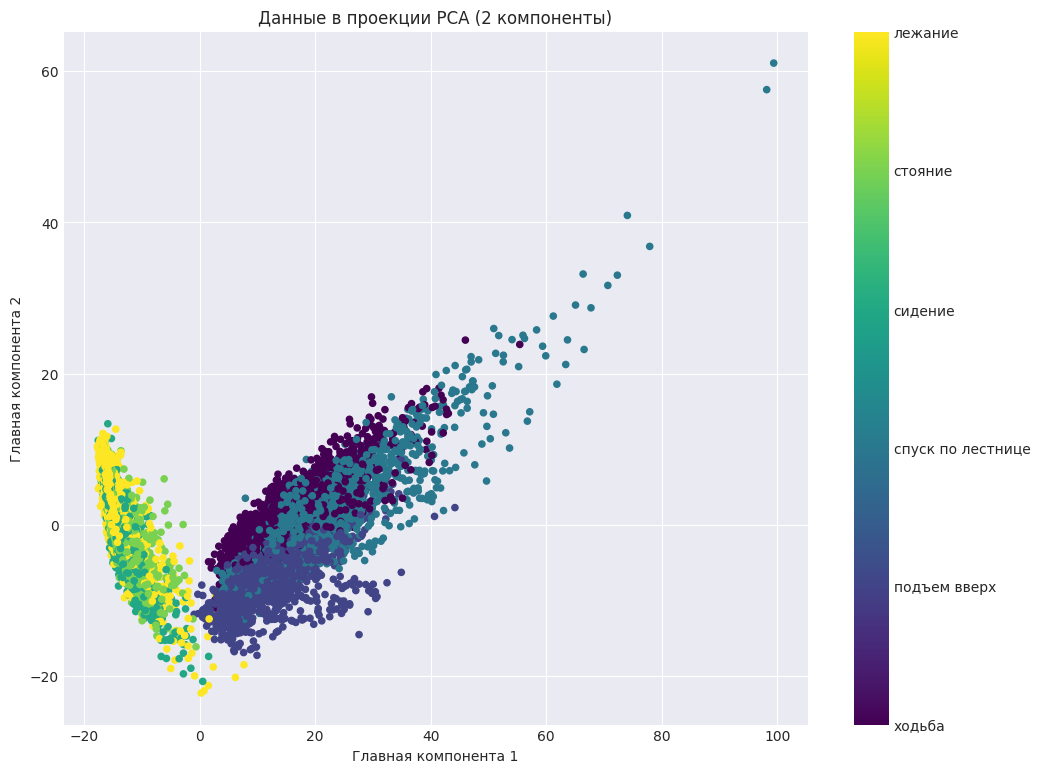

Обучение CustomKMeans...


KMeans n_init runs:   0%|          | 0/100 [00:00<?, ?it/s]

Обучение sklearn.KMeans...
Sklearn.KMeans обучен.

Inertia (Custom): 2003454.20
Inertia (Sklearn): 2003454.90


In [33]:
# Ваш код здесь
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
cbar = plt.colorbar(ticks=range(1, n_classes + 1))
cbar.set_ticklabels(['ходьба', 'подъем вверх', 'спуск по лестнице', 'сидение', 'стояние', 'лежание'])
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Данные в проекции PCA (2 компоненты)')
plt.show()


**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

Ответ 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)


------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [20]:
# Ваш код здесь
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

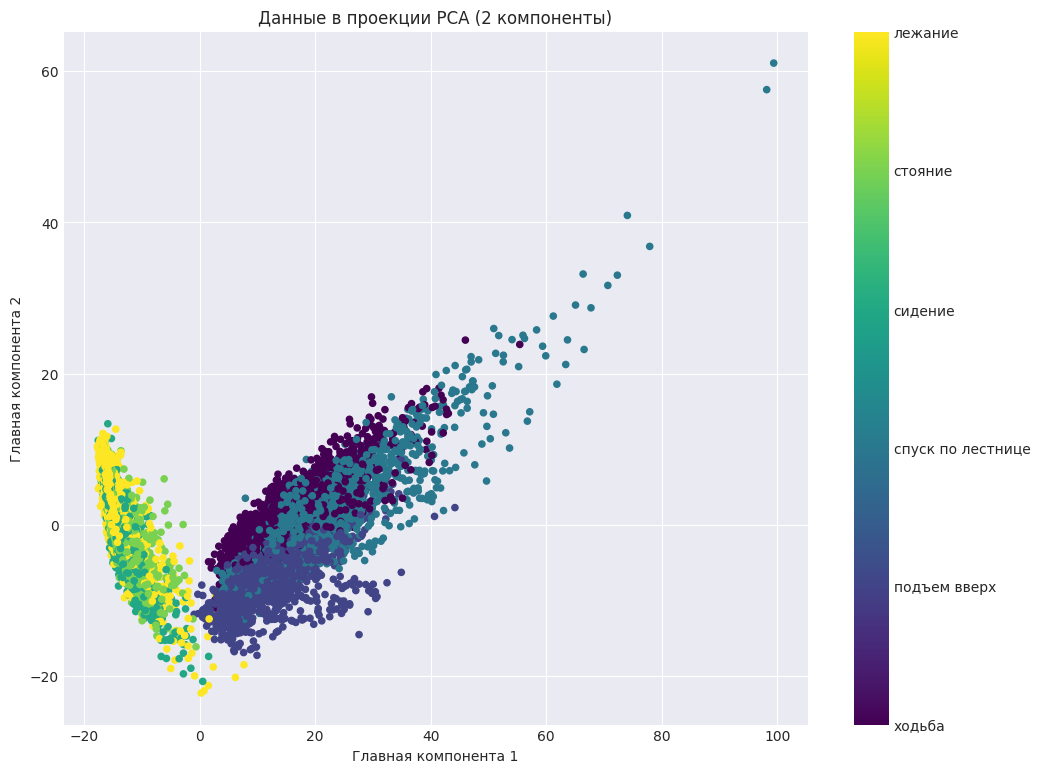

Обучение CustomKMeans...


KMeans n_init runs:   0%|          | 0/100 [00:00<?, ?it/s]

Обучение sklearn.KMeans...
Sklearn.KMeans обучен.

Inertia (Custom): 2003454.20
Inertia (Sklearn): 2003454.90


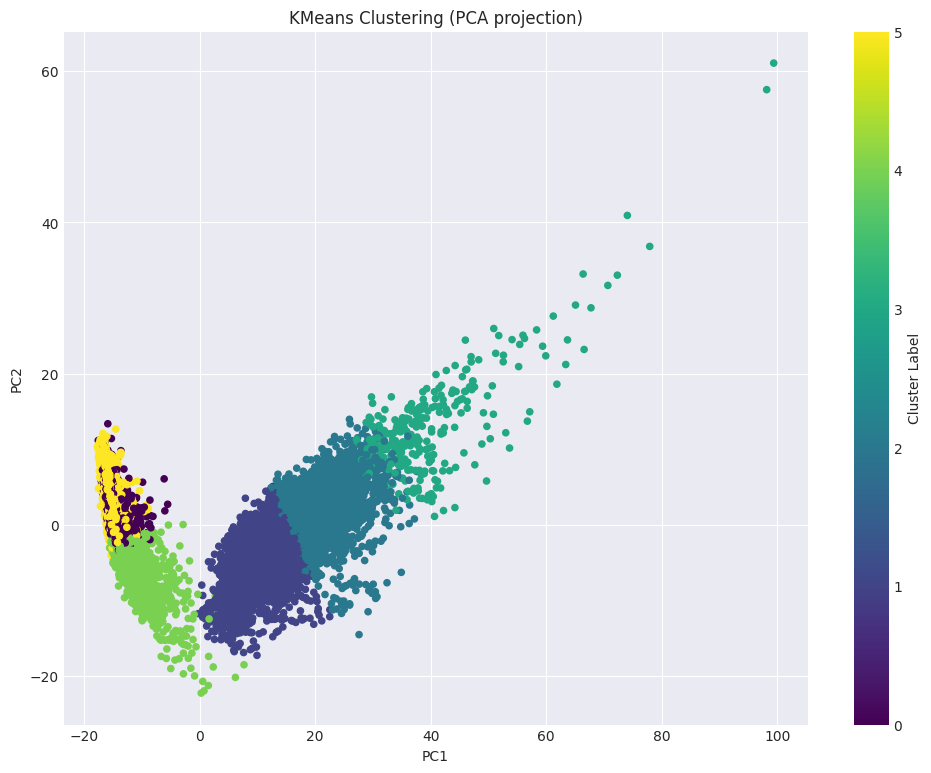


Таблица соответствия классов и кластеров (KMeans):
                          cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       903       741        78         0   
подъем вверх по лестнице         0      1241       296         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                       1235         1         0         0       450   
стояние                       1344         0         0         0       562   
лежание                         52         5         0         0       329   
все                           2631      2470      1927       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                         91   1777  
стояние                          0   1906  
лежание                       1558   1944  
все            

In [36]:
# Ваш код здесь
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
cbar = plt.colorbar(ticks=range(1, n_classes + 1))
cbar.set_ticklabels(['ходьба', 'подъем вверх', 'спуск по лестнице', 'сидение', 'стояние', 'лежание'])
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Данные в проекции PCA (2 компоненты)')
plt.show()

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

class CustomKMeans:
    def __init__(self, n_clusters, n_init=10, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = np.inf

    def fit(self, X):
        np.random.seed(self.random_state)
        best_inertia = np.inf
        best_centers = None
        best_labels = None

        for i in tqdm(range(self.n_init), desc="KMeans n_init runs"):
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            centers = X[indices]
            
            for _ in range(self.max_iter):
                distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
                labels = np.argmin(distances, axis=1)
                
                new_centers = np.empty_like(centers)
                moved = False

                for j in range(self.n_clusters):
                    cluster_points = X[labels == j]
                    if len(cluster_points) > 0:
                        new_center = cluster_points.mean(axis=0)
                        if not np.allclose(centers[j], new_center):
                            moved = True
                        new_centers[j] = new_center
                    else:
                        new_centers[j] = centers[j]
                
                if not moved: 
                    break
                    
                centers = new_centers
            current_inertia = 0
            for j in range(self.n_clusters):
                cluster_points = X[labels == j]
                if len(cluster_points) > 0:
                    current_inertia += np.sum((cluster_points - centers[j])**2)

            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centers = centers
                best_labels = labels
        
        self.cluster_centers_ = best_centers
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self
        

n_clusters = n_classes  # 6
n_init = 100

# 1. Обучаем СОБСТВЕННУЮ реализацию
print("Обучение CustomKMeans...")
custom_kmeans = CustomKMeans(n_clusters=n_clusters, n_init=n_init, random_state=RANDOM_STATE)
custom_kmeans.fit(X_pca)
custom_labels = custom_kmeans.labels_

# 2. Обучаем SKLEARN реализацию (ДОБАВЛЕННЫЙ БЛОК)
print("Обучение sklearn.KMeans...")
sklearn_kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=RANDOM_STATE)
sklearn_kmeans.fit(X_pca)
sklearn_labels = sklearn_kmeans.labels_
print("Sklearn.KMeans обучен.")

print(f"\nInertia (Custom): {custom_kmeans.inertia_:.2f}")
print(f"Inertia (Sklearn): {sklearn_kmeans.inertia_:.2f}")

# Используем метки sklearn для дальнейшего ответа на Вопрос 4
cluster_labels = sklearn_labels

# Визуализация данных
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.title("KMeans Clustering (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster Label')
plt.show()

tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
print("\nТаблица соответствия классов и кластеров (KMeans):")
print(tab)

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [37]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
print("\nТаблица соответствия классов и кластеров (KMeans):")
print(tab)


Таблица соответствия классов и кластеров (KMeans):
                          cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       903       741        78         0   
подъем вверх по лестнице         0      1241       296         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                       1235         1         0         0       450   
стояние                       1344         0         0         0       562   
лежание                         52         5         0         0       329   
все                           2631      2470      1927       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                         91   1777  
стояние                          0   1906  
лежание                       1558   1944  
все            

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

In [38]:
max_ratios = (tab.iloc[:-1, :-1].max(axis=1) / tab.iloc[:-1, -1])
print("Максимальная доля объектов в классе, отнесенных к одному кластеру:")
print(max_ratios)

Максимальная доля объектов в классе, отнесенных к одному кластеру:
ходьба                      0.524390
подъем вверх по лестнице    0.803756
спуск по лестнице           0.633001
сидение                     0.694992
стояние                     0.705142
лежание                     0.801440
dtype: float64


Ответ :перечисленные варианты не подходят (т.к. вариант подъем вверх по лестнице)

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

C:\Users\79151\AppData\Local\Temp\ipykernel_25380\3765576442.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1), desc="KMeans Inertia"):


KMeans Inertia:   0%|          | 0/6 [00:00<?, ?it/s]

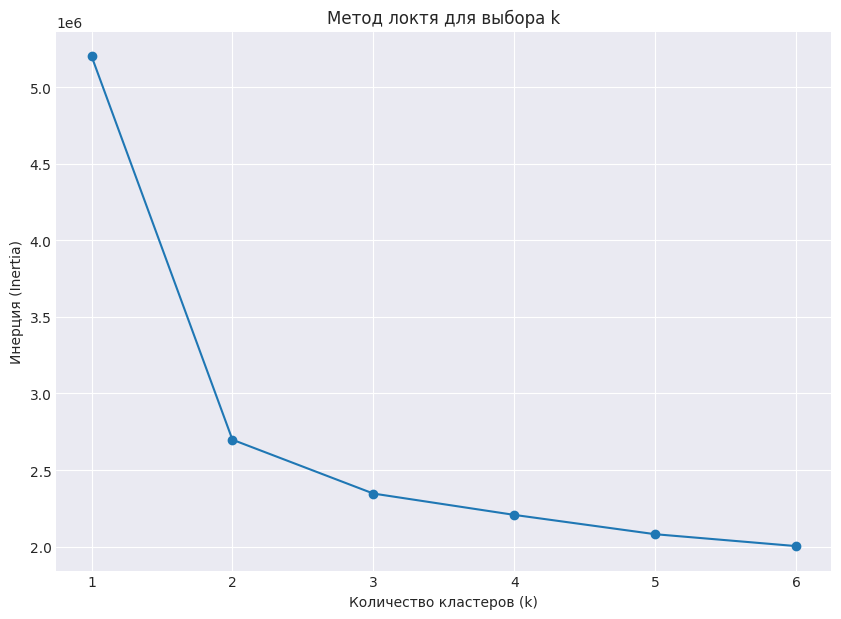

In [39]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1), desc="KMeans Inertia"):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (Inertia)')
plt.title('Метод локтя для выбора k')
plt.xticks(range(1, n_classes + 1))
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

Ответ 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [41]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [43]:
# Ваш код здесь
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)
ag_labels = ag.labels_
ari_kmeans = metrics.adjusted_rand_score(y, cluster_labels)
ari_ag = metrics.adjusted_rand_score(y, ag_labels)

print(f"ARI для KMeans: {ari_kmeans:.4f}")
print(f"ARI для Agglomerative Clustering: {ari_ag:.4f}")

ARI для KMeans: 0.4198
ARI для Agglomerative Clustering: 0.4936


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Ответ все утвержденият верны


-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [45]:
# Ваш код здесь
scaler_svc = StandardScaler()
X_train_scaled = scaler_svc.fit_transform(X_train)
X_test_scaled = scaler_svc.transform(X_test)

In [59]:
svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [47]:
# Ваш код здесь
best_svc = GridSearchCV(svc, svc_params, cv=3, verbose=1, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\users\79151\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\users\79151\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [50]:
# Ваш код здесь
print(f"Лучшее значение C: {best_svc.best_params_['C']}")
print(f"Лучшее качество на кросс-валидации (без PCA): {best_svc.best_score_:.4f}")
y_predicted = best_svc.predict(X_test_scaled)


Лучшее значение C: 0.1
Лучшее качество на кросс-валидации (без PCA): 0.9383


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

Ответ 0.1


In [51]:
y_predicted = best_svc.predict(X_test_scaled)

In [54]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,3,414,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,468,414,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

**ответ по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4%
- 10%
- 20%


In [65]:
pca_svc = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca_svc.fit_transform(X_train_scaled)
X_test_pca = pca_svc.transform(X_test_scaled)

# Настройка гиперпараметра C с помощью GridSearchCV на данных с PCA
svc_pca = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

best_svc_pca = GridSearchCV(svc_pca, svc_params, cv=3, verbose=1, n_jobs=-1)
best_svc_pca.fit(X_train_pca, y_train)

print(f"Лучшее значение C с PCA: {best_svc_pca.best_params_['C']}")
print(f"Лучшее качество на кросс-валидации (с PCA): {best_svc_pca.best_score_:.4f}")

diff_quality = (best_svc.best_score_ - best_svc_pca.best_score_) * 100
print(f"Разность в качестве (без PCA - с PCA): {diff_quality:.2f}%")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\users\79151\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Лучшее значение C с PCA: 0.1
Лучшее качество на кросс-валидации (с PCA): 0.8984
Разность в качестве (без PCA - с PCA): 3.99%


Ответ 4

**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

Ответ - PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

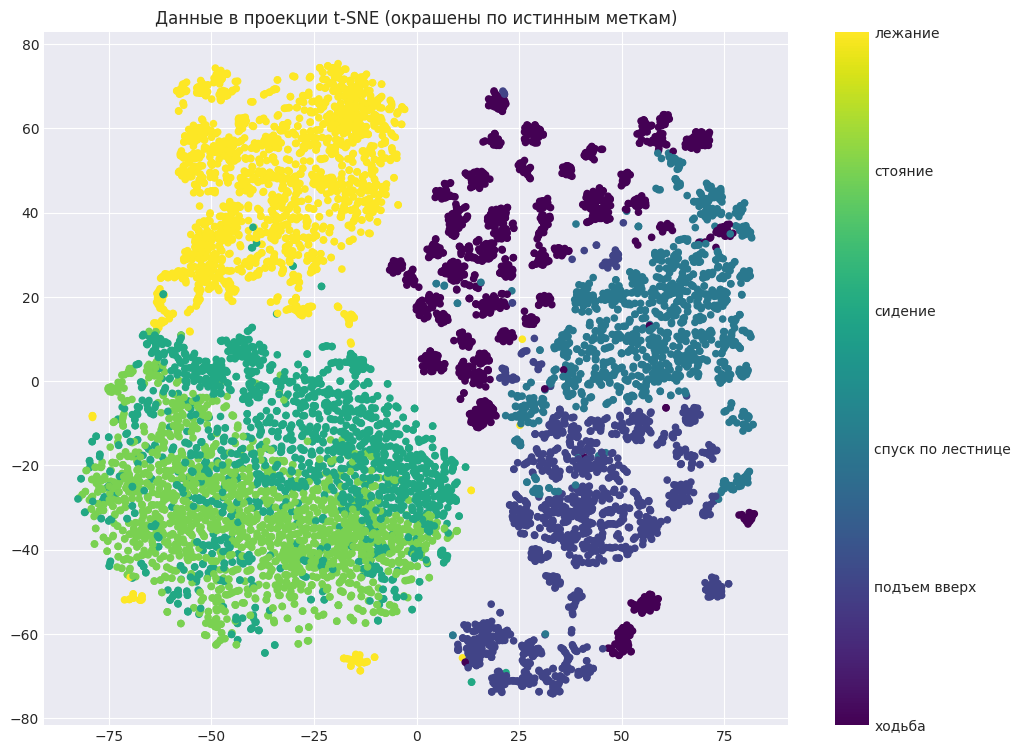

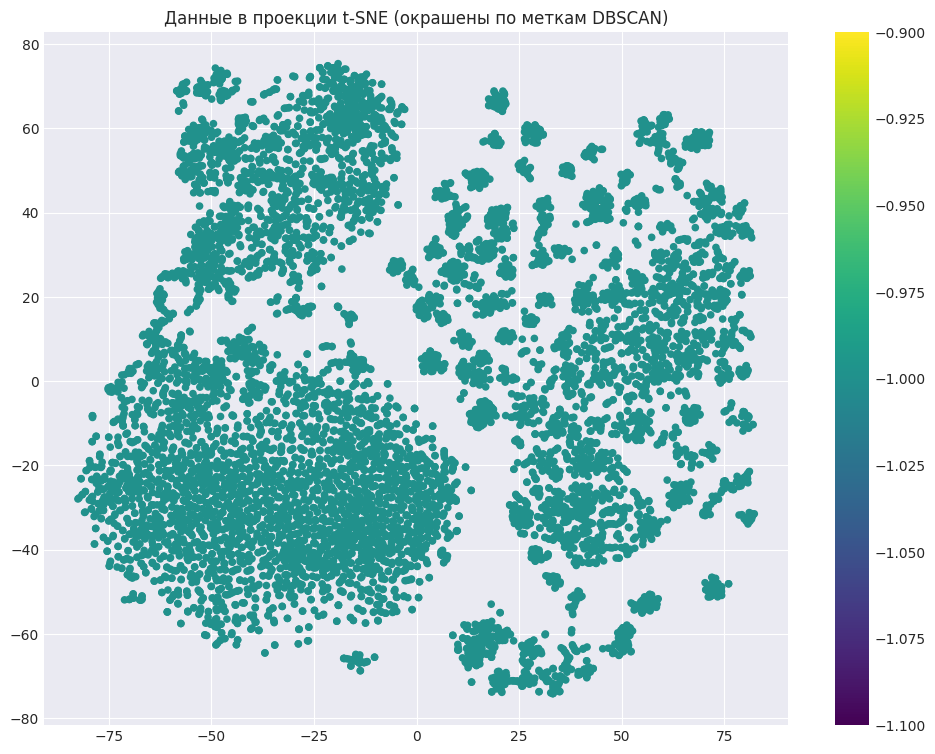

Количество кластеров, найденных DBSCAN (без шума): 0
Количество шумовых точек: 10299
ARI для DBSCAN (на t-SNE): 0.0000


In [67]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
cbar = plt.colorbar(ticks=range(1, n_classes + 1))
cbar.set_ticklabels(['ходьба', 'подъем вверх', 'спуск по лестнице', 'сидение', 'стояние', 'лежание'])
plt.title('Данные в проекции t-SNE (окрашены по истинным меткам)')
plt.show()

dbscan = DBSCAN(eps=3.5, min_samples=100)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.colorbar()
plt.title('Данные в проекции t-SNE (окрашены по меткам DBSCAN)')
plt.show()

n_clusters_dbscan = len(np.unique(dbscan_labels[dbscan_labels != -1]))
noise_points = np.sum(dbscan_labels == -1)
ari_dbscan = metrics.adjusted_rand_score(y, dbscan_labels)

print(f"Количество кластеров, найденных DBSCAN (без шума): {n_clusters_dbscan}")
print(f"Количество шумовых точек: {noise_points}")
print(f"ARI для DBSCAN (на t-SNE): {ari_dbscan:.4f}")